# 0. 前期准备工作

In [46]:
# 超参数
BATCH_SIZE = 4
NUM_WORKERS = 0
LEARNING_RATE = 0.001
MOMENTUM = 0.9

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# datasets
train_set = torchvision.datasets.FashionMNIST(
    root='./data/datasets',
    download=True,
    train=True,
    transform=transform,
)
test_set = torchvision.datasets.FashionMNIST(
    root='./data/datasets',
    download=True,
    train=False,
    transform=transform,
)

# dataloaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# 显示图像
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()
    if one_channel:
        plt.imshow(np_img, cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img, (1, 2, 0)))

In [48]:
# 定义模型
# input: [b, 1, 28, 28]
# output: [b, 10]
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, in_):
        # in_: [b, 1, 28, 28]
        # -> [b, 6, 14, 14]
        out = self.pool(F.relu(self.conv1(in_)))

        # -> [b, 16, 7, 7]
        out = self.pool(F.relu(self.conv2(out)))

        # -> [b, 16 * 7 * 7]
        out = out.view(out.size(0), -1)

        # -> [b, 10]
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)

        return out

In [49]:
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# 1. TensorBoard的初始化

In [50]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./data/runs/fashion_mnist_experiment_1")

# 2. 写入TensorBoard

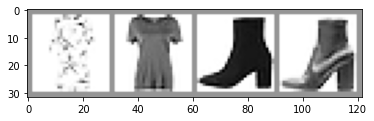

In [51]:
imgs, labels = next(iter(train_loader))

img_grid = torchvision.utils.make_grid(imgs)
matplotlib_imshow(img_grid, one_channel=True)

writer.add_image("four_fashion_mnist_images", img_grid)


然后在命令行中执行“tensorboard --logdir=./data/runs”，
即可在浏览器中打开TensorBoard。
![01](./img/01.jpg)

# 3. 在TensorBoard显示模型结构

In [52]:
writer.add_graph(model, imgs)
writer.close()

刷新TensorBoard网页页面，此时可以在“Graphs”标签中看到模型结构。
![02](./img/02.jpg)

# 4. 投影
可以将高维数据投影到低维空间进行可视化。

In [53]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

def select_n_random(data, labels, n):
    assert len(data) == len(labels)
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

imgs, labels = select_n_random(train_set.data, train_set.targets, 100)

class_labels = [classes[label] for label in labels]

features = imgs.view(-1, 28 * 28)
writer.add_embedding(features,
                     metadata=class_labels,
                     label_img=imgs.unsqueeze(1))
writer.close()

![03](./img/03.jpg)

# 5. 跟踪模型训练情况

未完待续。